## Logistic Regression
In class, we have learned logistic regression which is widely used on classification tasks. We have also learned gradient descent, which is a first-order iterative optimization algorithm for finding the minimum of a function. Now we will make some experiments to show how gradient descent can be used on logistic regression. We are going to use `numpy` and `matplotlib` packages in our experiments, the first thing we need to do is to import them.

In [1]:
%matplotlib inline
# import packages
import numpy as np
import matplotlib.pyplot as plt
# time packages are used to measure the convergence speed
import time
# there might be some warnings due to the different versions of python and packages you installed.
# here we choose to suppress these warnings.
# but don't ignore warnings unless you know you are absolutely right!
import warnings
warnings.filterwarnings("ignore")

Our experiment consists of two sub-experiments:
- Logistic regression with batch gradient descent.
- Logistic regression with stochastic gradient descent.

Each sub-experiment consists of 3 steps:
1. Generation of training dataset.
2. Implementation of algorithms.
3. Visualization of experimental results.

And we will have an analytical question in the end.

### Logistic regression with batch gradient descent
#### Generation of training dataset
Given a feature vector $\boldsymbol x$, the linear combination of features can be written as:
$$
\sum_{i=1}^n {\boldsymbol w_i \boldsymbol x_i} + b
$$
where $\boldsymbol w$ is the weight vector and $b$ is bias. We can easily compact bias into matrix multiplication by adding another dimension:
$$
\sum_{i=1}^n {\boldsymbol w_i \boldsymbol x_i} + b = \boldsymbol{\theta}^{T} \boldsymbol{x} 
$$
where $\boldsymbol{x} = [\boldsymbol x_1\cdots \boldsymbol x_n, 1]^T, \boldsymbol\theta = [\boldsymbol w_1\cdots \boldsymbol w_n, b]^T$. Logistic model is defined by by applying the *sigmoid* function on the linear combination of features 
$$h_{\boldsymbol \theta}(\boldsymbol{x})= g(\boldsymbol{\theta}^{T} \boldsymbol{x}) = \frac{1}{1+\exp \left(-\boldsymbol{\theta}^{T} \boldsymbol{x}\right)}.$$
Because sigmoid function is bounded in $(0, 1)$, we can consider $h_{\boldsymbol \theta}$ as probability. Now define our sigmoid function.

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

We will generate training data based on the defination of logistic model. Here we only consider the simplest case, which means the number of features is set as $1$. You can choose to add bias on the model. If you set `with_bias` as true, the last element of $\boldsymbol \theta$ is the bias. We also just set $\boldsymbol \theta = \boldsymbol 1$, where $\boldsymbol 1$ is a vector with all components equal to $1$.

In [3]:
num_features = 1
with_bias = True
theta_ = np.ones(num_features + int(with_bias))

Now assume we have an observation matrix $\boldsymbol X$, we can compute the probability vector $\boldsymbol p$ of these samples through $h_{\boldsymbol \theta}(\boldsymbol{x}).$

In [4]:
def predict_probability(X, theta):
    # X@y is equivalent to np.matmul(X, y)
    return sigmoid(X@theta)

The label vector $\boldsymbol y$ will be determined through a threshold based on the probability vector
$$
\boldsymbol{y}^{(i)} = \left\{
\begin{matrix}
1 & {\text{if } \boldsymbol{p}_i > 0.5}\\
0 & \text{otherwise}
\end{matrix}\right..
$$

In [5]:
def predict_label(X, theta):
    return (predict_probability(X, theta) > 0.5).astype(float)

Integrate the above content, we can write a function to randomly generate training data of binary classification. You just need to input the number of samples, weight vector and bias option and the function will return observation matrix $\boldsymbol X$ and label vector $\boldsymbol y$. 

In [6]:
def generate_binary_classification_data(num_samples, theta, bias = True):
    if bias == False:
        X = (np.random.rand(num_samples, theta.shape[0]) - 0.5) * 4
    else:
        # place the center of X on (-bias)
        X = (np.random.rand(num_samples, theta.shape[0] - 1) - 0.5) * 4 - theta[-1]
        # add another dimension for bias
        X = np.insert(X, X.shape[1], 1, axis=1)
    y = predict_label(X, theta)
    return X, y

Now generate $100$ training samples.

In [7]:
X, y = generate_binary_classification_data(100, theta_, with_bias)
print(X)
print(y)

[[-0.00786053  1.        ]
 [ 0.90392559  1.        ]
 [-0.52835928  1.        ]
 [-1.59729271  1.        ]
 [ 0.85912134  1.        ]
 [ 0.1029982   1.        ]
 [-1.44635736  1.        ]
 [ 0.27269411  1.        ]
 [-0.31793799  1.        ]
 [ 0.85751671  1.        ]
 [-0.93350768  1.        ]
 [ 0.09411776  1.        ]
 [-0.79808987  1.        ]
 [-1.26658578  1.        ]
 [-0.84673078  1.        ]
 [-0.84689086  1.        ]
 [-2.87315666  1.        ]
 [-1.86937472  1.        ]
 [-0.22118568  1.        ]
 [-1.4916372   1.        ]
 [-2.7629145   1.        ]
 [-2.87621405  1.        ]
 [-2.29535107  1.        ]
 [ 0.50288159  1.        ]
 [-1.10204037  1.        ]
 [-1.02318192  1.        ]
 [-2.46560157  1.        ]
 [ 0.78995807  1.        ]
 [-1.19175365  1.        ]
 [ 0.78897364  1.        ]
 [ 0.85694222  1.        ]
 [-1.73989272  1.        ]
 [-2.29452849  1.        ]
 [-0.74166784  1.        ]
 [-1.58607647  1.        ]
 [-1.86834547  1.        ]
 [-2.79693084  1.        ]
 

#### Implementation of algorithms
We know that using maximal likelihood to estimate the parameters of logistic regression model is equivalent to maximize:
$$
\mathcal l(\boldsymbol \theta)=\sum_{i=1}^{m} y^{(i)} \log h_{\boldsymbol \theta}\left(\boldsymbol{x}^{(i)}\right)+\left(1- y^{(i)}\right) \log \left(1-h_{\boldsymbol \theta}\left(\boldsymbol{x}^{(i)}\right)\right).
$$
And based on above formula, we can define our log-loss function in python.

In [8]:
def log_loss(X, y, theta):
    y_expand = np.vstack([1 - y, y])
    predicted_prob = predict_probability(X, theta)
    predicted_prob = np.vstack([1-predicted_prob, predicted_prob])
    # here we add an small vaue to avoid Nan
    predicted_prob += 1e-4 * (predicted_prob == 0).astype(float)
    # X*y is element-wise production
    return -np.sum(y_expand * np.log(predicted_prob))    
print(log_loss(X, y, theta_))

33.27822694382282


Also I want to mention that, for classification problems, prediction accuracy is a more intuitive way to measure the performance of algorithms.

In [9]:
def accuracy(X, y, theta):
    predicted_label = predict_label(X, theta)
    return np.sum((predicted_label == y).astype(float)) / y.shape[0]
print(accuracy(X, y, theta_))

1.0


The gradient of $l(\boldsymbol\theta)$ can be computed through
$$
\frac{\partial l(\boldsymbol\theta)}{\partial \boldsymbol\theta_{j}}=\sum_{i=1}^{m}\left(y^{(i)}-h_{\boldsymbol\theta}\left(\boldsymbol x^{(i)}\right)\right) \boldsymbol x_{j}^{(i)}.
$$
In gradient descent, we update the weights through
$$
\boldsymbol\theta := \boldsymbol\theta - \alpha \nabla J(\boldsymbol\theta)
$$
where $\alpha$ is the learning rate. Here we want to maximize $\mathcal l(\boldsymbol \theta)$, the update rule becomes
$$
\boldsymbol \theta_{j}:=\boldsymbol \theta_{j}+\alpha \sum_{i=1}^{m}\left(y^{(i)}-h_{\boldsymbol \theta}\left(\boldsymbol x^{(i)}\right)\right) \boldsymbol x_{j}^{(i)} \text { for every } j.
$$
Now let us transfer this formula into codes. Instead of using a foor-loop, we prefer to use matrix operations because it's much more efficient.

In [10]:
def iteration_step_bgd(X, y, theta, alpha = 0.1):
    theta = theta + alpha * X.transpose() @ (y - sigmoid(X @ theta))
    return theta

This algorithm is known as batch gradient descent (BGD) because we only update the weights after we have seen all training samples. 
#### Visualization of experimental results
So far we have finished BGD algorithm. We can write some simple codes to test our implementation immediately. In the following code, we will train our logistic model for a certain amount of epochs. During the training process, we will print the log-loss and accuracy. We also plot our model step by step to better illustrate how the weights change.

iter 0, log-loss: 69.31471805599452, accuracy: 0.54
iter 25, log-loss: 33.89103490769825, accuracy: 0.87
iter 50, log-loss: 26.31224452515636, accuracy: 0.92
iter 100, log-loss: 19.729432587268192, accuracy: 0.93
iter 200, log-loss: 14.813987746579656, accuracy: 0.97
iter 400, log-loss: 11.308274245774074, accuracy: 0.99
iter 800, log-loss: 8.746580589004134, accuracy: 0.99
iter 1600, log-loss: 6.792058933168268, accuracy: 0.99


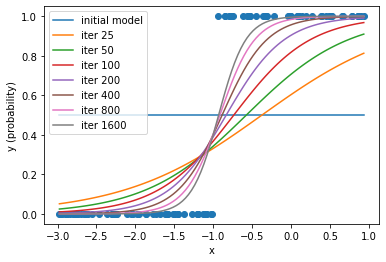

In [11]:
# zero initialization
theta = np.zeros_like(theta_)
alpha = 0.002
plt.scatter(X[:,0], y)
# plot the probability curve
x_uni = np.array([np.linspace(np.min(X[:, 0]), np.max(X[:,0]), 100)]).transpose()
if with_bias:
    x_uni = np.insert(x_uni, 1, 1, axis=1)
y_ = predict_probability(x_uni, theta)
plt.plot(x_uni[:,0], y_, label="initial model")
print(r'iter {}, log-loss: {}, accuracy: {}'.format(0, log_loss(X, y, theta), accuracy(X, y, theta)))
plot_id = 25
# 1600 iteration steps
for iter_step in range(1600):
    theta = iteration_step_bgd(X, y, theta, alpha)
    if iter_step+1 == plot_id:
        plot_id *= 2
        print(r'iter {}, log-loss: {}, accuracy: {}'.format(iter_step+1, log_loss(X, y, theta), accuracy(X, y, theta)))
        y_ = predict_probability(x_uni, theta)
        plt.plot(x_uni[:,0], y_, label=r"iter {}".format(iter_step+1))
    iter_step += 1
plt.xlabel("x")
plt.ylabel("y (probability)")
plt.legend()

### Logistic regression with stochastic gradient descent
#### Generation of training dataset
In class we also learned stochastic gradient descent (SGD), in which we only use one sample to compute the gradient and update the weight:
$$
\begin{aligned}
\text{for } i=&1\cdots m,\\
&\boldsymbol \theta_{j}:=\boldsymbol \theta_{j}+\alpha\left(y^{(i)}-h_{\boldsymbol \theta}\left(\boldsymbol x^{(i)}\right)\right) \boldsymbol x_{j}^{(i)} \text { for every } j.
\end{aligned}
$$
We know that SGD has a much faster convergence speed than BGD especially on large dataset. Now let's do some experiments to verify it. First, we need to generate a larger dataset.

In [12]:
number_features = 2
theta_ = np.ones(number_features + int(with_bias))
X, y = generate_binary_classification_data(50000, theta_)

 #### Implementation of algorithms
 To compare the speed, we need to train two logistic models using BGD and SGD respectively. Now initailize two weight vectors with zero vector, the first one will be updated through BGD and the second one will be updated through SGD.

In [13]:
# weight of our first model using bgd
theta_bgd = np.zeros_like(theta_)
# weight of our second model using sgd
theta_sgd = np.zeros_like(theta_)

#### Q1. Now please implement SGD by completing following code. Note that in each iteration step of SGD, we will only see one training sample. Therefore, `X` is a feature vector rather than a matrix, and `y` is a scalar rather than a vector.

In [14]:
def iteration_step_sgd(X, y, theta, alpha = 0.1):
    # write your implementation here.
    theta = theta + alpha * (y - sigmoid(X @ theta)) * X
    return theta

#### Visualization of experimental results
Now we have implemented SGD algorithm. We still need to write some scripts to test our models. We have a `train_for_seconds` function here. You just need to input observation matrix $\boldsymbol X$ and label vector $\boldsymbol y$, weight vector $\boldsymbol\theta$ and flag of gradient descent method you want to use (0 for BGD and 1 for SGD). It will help you to train the model based on you implementation. Specifically, it will train the input model `t` seconds, and return elapsed time and corresponding log-losses which can be directly used to draw the learning curve. 

In [15]:
def train_for_seconds(X, y, theta, gd_method = 0, alpha = 1, t = 2, k = 5, n = 500):
    iter_step_id = 0
    time_axis = [0]
    train_loss = [log_loss(X, y, theta)]
    stored_t = []
    stored_weights = []
    if gd_method == 0:
        alpha /= X.shape[0]
    start = time.perf_counter()
    while True:
        # train the model
        if gd_method == 0:
            theta = iteration_step_bgd(X, y, theta, alpha)
        elif gd_method == 1:
            theta = iteration_step_sgd(X[iter_step_id%X.shape[0]], y[iter_step_id%y.shape[0]], theta, alpha)
        curr = time.perf_counter()
        iter_step_id += 1
        if iter_step_id % k == 0:
            stored_t.append(curr - start)
            stored_weights.append(theta.copy())
        if curr - start > t:
            break
    n = min(n, len(stored_t))
    uni_samples = [ int(x) for x in np.floor(np.linspace(0, len(stored_t)-1, n))]
    for us in uni_samples:
        time_axis.append(stored_t[us])
        train_loss.append(log_loss(X, y, stored_weights[us]))
    time_axis.append(curr - start)
    train_loss.append(log_loss(X, y, theta))
    return time_axis, train_loss, iter_step_id

Now everything is ready. We will spend the same time training these two models. After that, the learning curves of both models will be plotted.

number of iteration (bgd): 1368
number of iteration (sgd): 318326


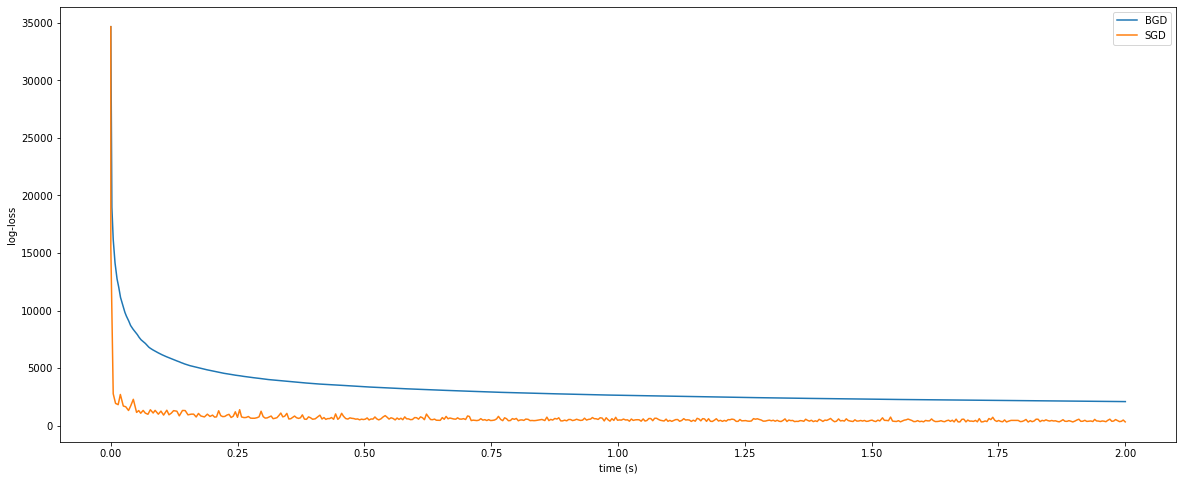

In [16]:
# train model for 2 seconds
t_bgd, loss_bgd, num_iter_bgd = train_for_seconds(X, y, theta_bgd, gd_method = 0, k = 1)
t_sgd, loss_sgd, num_iter_sgd = train_for_seconds(X, y, theta_sgd, gd_method = 1, k = 5)
print("number of iteration (bgd):", num_iter_bgd)
print("number of iteration (sgd):", num_iter_sgd)
# plot the learning curve 
plt.figure(figsize=(20, 8))
plt.plot(t_bgd, loss_bgd)
plt.plot(t_sgd, loss_sgd)
plt.xlabel("time (s)")
plt.ylabel("log-loss")
plt.legend(["BGD", "SGD"])

### Analytical question 
#### Q2. If your implementation is correct, you should see that the log-loss decreases first and then oscillates near the minimum. Change the number of training samples to get different results, then compare the curves and explain what you have seen.

**Your answer:** The SGD converge faster than BGD. Because SGD iterate more times. When the dataset become larger, the gap between numbers of iterations will be even greater. However, the curve of BGD is smoother, because it compute the gradient using all samples. And SGD only use one sample, which makes it more sensitive to noise and the direction might not be the optimal. Therefore it oscillates near the minimum. 